In [1]:
from keras.models import Sequential
from keras.layers import Dense,Dropout, Flatten,LSTM,RepeatVector,TimeDistributed,Conv1D,MaxPooling1D
from keras.callbacks import EarlyStopping
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

from livelossplot.keras import PlotLossesCallback

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math
import numpy as np
from nsepy import get_history
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm

In [2]:
nifty = get_history(symbol='RELIANCE',
                   start=date(2000,1,1),
                   end=date(2019,1,1))


In [3]:
nifty.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


In [4]:
#rmseanalysis=[] ######diCTIONARY TO STORE THE RESULT RMSE VALUE##########
dictt={}

In [7]:
def my_function(a,dictt):
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Close Prices')
    plt.plot(nifty['Close'])
    plt.title('nifty closing price')
    plt.show()
   
    nifty['Date'] = nifty.index
    data2 = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
    data2['Date'] =  nifty['Date']
    data2['Open'] = nifty['Open']
    data2['High'] = nifty['High']
    data2['Low'] = nifty['Low']
    data2['Close'] = nifty['Close']

    train_set = data2.iloc[:, 4:5].values

    b=train_set.shape[0]

    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(train_set)

    ####### This step is for creating the dataset in the right shape ###### Here 60 can be a hyperparameter ######

    X_train = []
    y_train = []
    for i in range(a, b-1):
        X_train.append(training_set_scaled[i-a:i, 0])
        y_train.append(training_set_scaled[i, 0]) 
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    ####### Model training #########

    regressor = Sequential()
    regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.10))
    regressor.add(LSTM(units = 100, return_sequences = True))
    regressor.add(Dropout(0.10))
    regressor.add(LSTM(units = 100, return_sequences = True))
    regressor.add(Dropout(0.10))
    regressor.add(LSTM(units = 100))
    regressor.add(Dropout(0.10))
    regressor.add(Dense(units = 1))

    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

    ####testdataframe#####
    testdataframe = get_history(symbol='RELIANCE',
                       start=date(2019,1,2),
                       end=date(2021,6,1))

    c=testdataframe.shape[0]
    testdataframe['Date'] = testdataframe.index
    testdata = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
    testdata['Date'] = testdataframe['Date']
    testdata['Open'] = testdataframe['Open']
    testdata['High'] = testdataframe['High']
    testdata['Low'] = testdataframe['Low']
    testdata['Close'] = testdataframe['Close']

    real_stock_price = testdata.iloc[:, 4:5].values
    real_stock_price_total=np.concatenate((train_set,real_stock_price), axis = 0)   #Total dataset#
    dataset_total = pd.concat((data2['Close'], testdata['Close']), axis = 0)   #Total dataset#

    inputs = dataset_total[len(dataset_total) - len(testdata) - a:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    X_test = []
    for i in range(a, c+a):
        X_test.append(inputs[i-a:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)


    plt.figure(figsize=(20,10))
    plt.plot(real_stock_price, color = 'green', label = 'SBI Stock Price')
    plt.plot(predicted_stock_price, color = 'red', label = 'Predicted SBI Stock Price')
    plt.title('SBI Stock Price Prediction')
    plt.xlabel('Trading Day')
    plt.ylabel('SBI Stock Price')
    plt.legend()
    plt.show()


    d=real_stock_price_total.shape[0]
    predicted_stock_price_total=np.concatenate((train_set,predicted_stock_price), axis = 0)   #Total dataset#

    df1= pd.DataFrame(data =real_stock_price_total , columns = ['Real'])
    df1.shape
    df2=pd.DataFrame(data =predicted_stock_price_total , columns = ['predicted'])
    e=d-c

    dataset_total_new = pd.concat((data2, testdata), axis = 0) 
    dataset_total_new.reset_index(drop=True)
    df11= pd.DataFrame(data = dataset_total_new['Date'], columns = ['Date'])
    df11=df11.reset_index(drop=True)
    result = pd.concat([df11, df1], axis=1)
    result.index=result["Date"]
    result_predicted=pd.concat([df11, df2], axis=1)

    result_predicted.index=result_predicted["Date"]

    plt.plot(result['Real'], 'maroon', label='real data')
    plt.plot(result_predicted['predicted'][e:], 'blue', label='predicted data')


    # report performance
    mse = mean_squared_error(real_stock_price,predicted_stock_price )
    print('MSE: '+str(mse))
    mae = mean_absolute_error(real_stock_price, predicted_stock_price)
    print('MAE: '+str(mae))
    rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
    print('RMSE: '+str(rmse))
    mape = np.mean(np.abs(predicted_stock_price - real_stock_price)/np.abs(real_stock_price))
    print('MAPE: '+str(mape))
    dictt[a]=rmse
   # return rmse

15 days

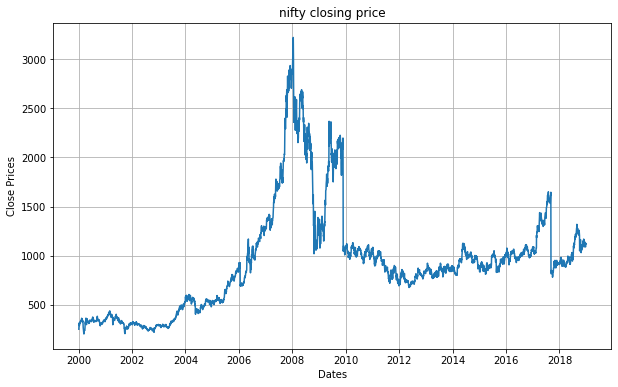

Epoch 1/100
148/148 [==============================] - 8s 19ms/step - loss: 0.0157
Epoch 2/100
148/148 [==============================] - 3s 20ms/step - loss: 0.0023
Epoch 3/100
148/148 [==============================] - 3s 22ms/step - loss: 0.0017
Epoch 4/100
148/148 [==============================] - 3s 20ms/step - loss: 0.0015
Epoch 5/100
148/148 [==============================] - 3s 20ms/step - loss: 0.0015
Epoch 6/100
148/148 [==============================] - 3s 20ms/step - loss: 0.0015
Epoch 7/100
148/148 [==============================] - 3s 20ms/step - loss: 0.0013
Epoch 8/100
148/148 [==============================] - 3s 20ms/step - loss: 0.0013
Epoch 9/100
148/148 [==============================] - 3s 22ms/step - loss: 0.0011
Epoch 10/100
148/148 [==============================] - 3s 21ms/step - loss: 0.0011
Epoch 11/100
148/148 [==============================] - 3s 20ms/step - loss: 0.0010
Epoch 12/100
148/148 [==============================] - 3s 20ms/step - loss: 0.0011
E

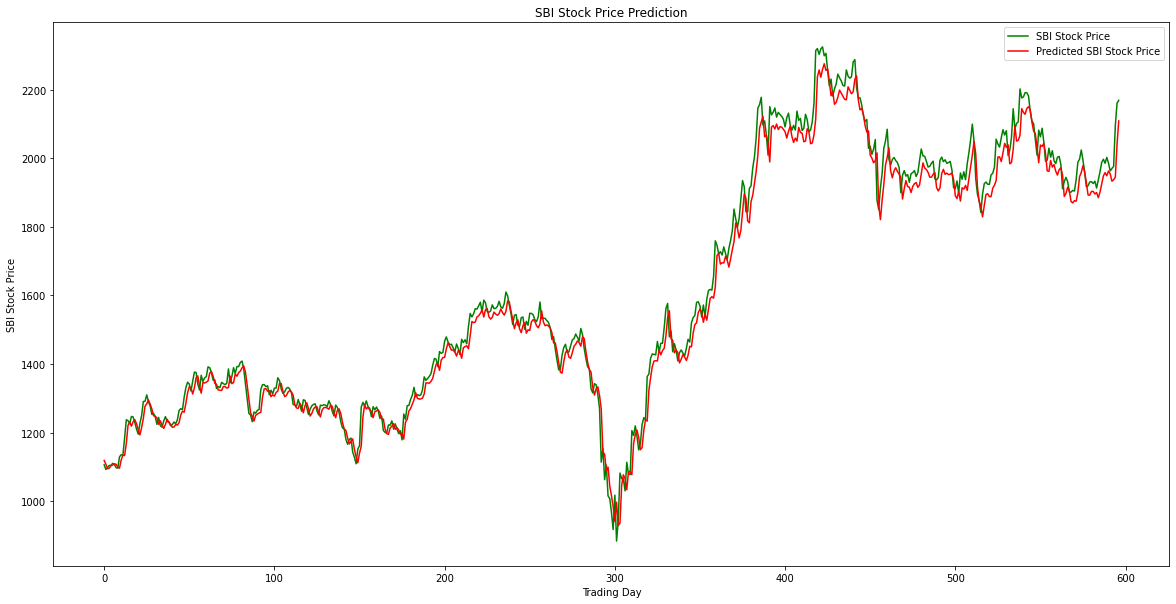

MSE: 1856.4477178653237
MAE: 32.40629482045644
RMSE: 43.08651433877338
MAPE: 0.019810455465136195


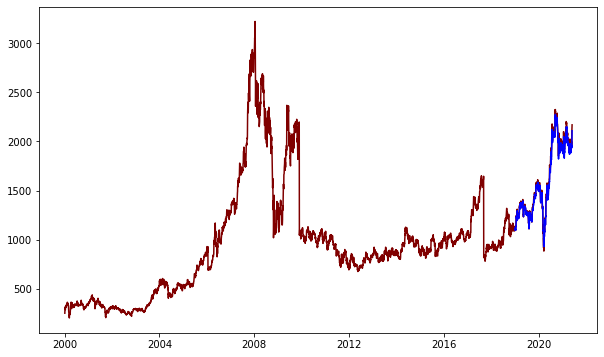

In [71]:
my_function(15,dictt)

30 days

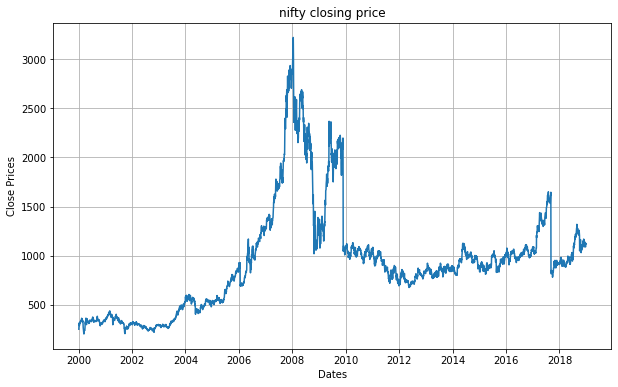

Epoch 1/100
147/147 [==============================] - 10s 36ms/step - loss: 0.0118
Epoch 2/100
147/147 [==============================] - 5s 35ms/step - loss: 0.0023
Epoch 3/100
147/147 [==============================] - 5s 36ms/step - loss: 0.0018
Epoch 4/100
147/147 [==============================] - 5s 36ms/step - loss: 0.0017
Epoch 5/100
147/147 [==============================] - 5s 36ms/step - loss: 0.0017
Epoch 6/100
147/147 [==============================] - 5s 36ms/step - loss: 0.0013
Epoch 7/100
147/147 [==============================] - 5s 36ms/step - loss: 0.0012
Epoch 8/100
147/147 [==============================] - 5s 36ms/step - loss: 0.0012
Epoch 9/100
147/147 [==============================] - 5s 36ms/step - loss: 0.0012
Epoch 10/100
147/147 [==============================] - 5s 37ms/step - loss: 0.0011
Epoch 11/100
147/147 [==============================] - 5s 36ms/step - loss: 9.5918e-04
Epoch 12/100
147/147 [==============================] - 5s 37ms/step - loss: 0.0

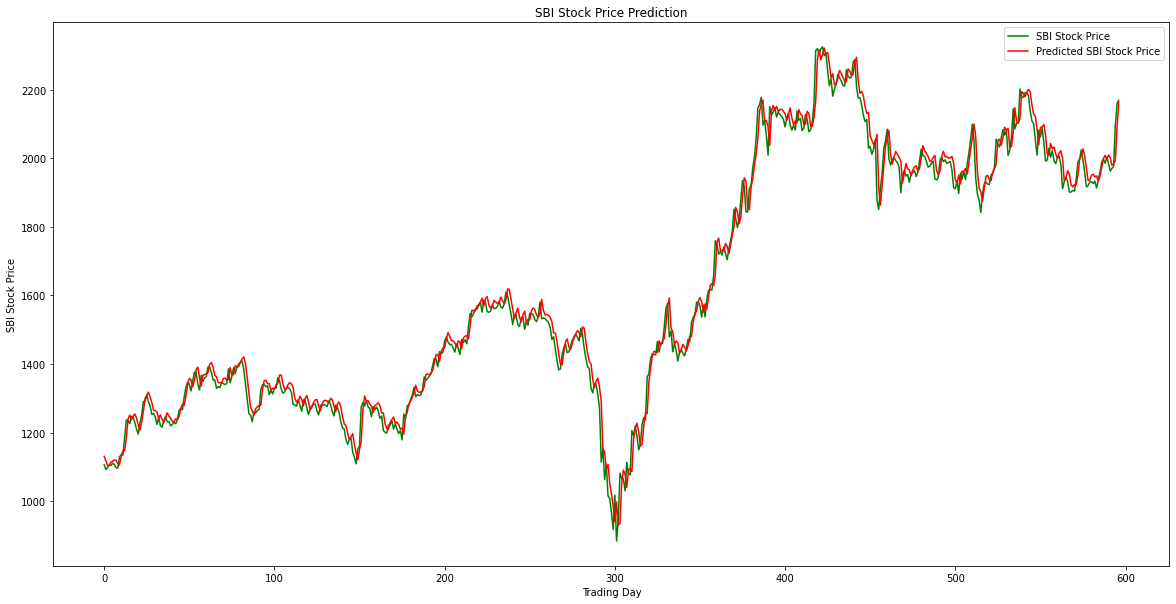

MSE: 1308.595452384563
MAE: 26.550587021206287
RMSE: 36.174513851392156
MAPE: 0.017104521946035834


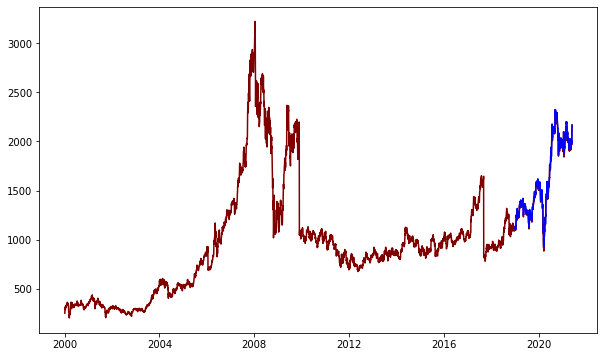

In [72]:
my_function(30,dictt)

45 days

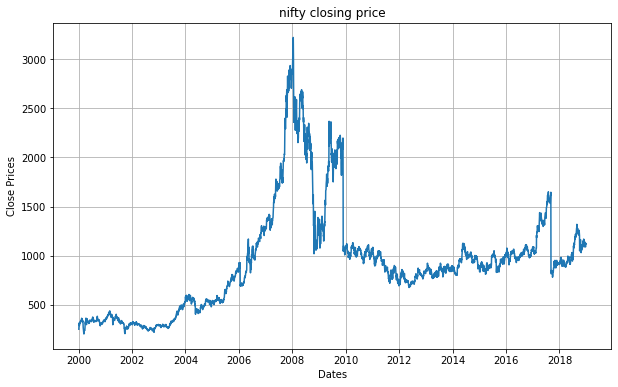

Epoch 1/100
147/147 [==============================] - 14s 62ms/step - loss: 0.0106
Epoch 2/100
147/147 [==============================] - 9s 61ms/step - loss: 0.0021
Epoch 3/100
147/147 [==============================] - 9s 62ms/step - loss: 0.0017
Epoch 4/100
147/147 [==============================] - 9s 64ms/step - loss: 0.0016
Epoch 5/100
147/147 [==============================] - 9s 63ms/step - loss: 0.0017
Epoch 6/100
147/147 [==============================] - 9s 62ms/step - loss: 0.0015
Epoch 7/100
147/147 [==============================] - 9s 63ms/step - loss: 0.0010
Epoch 8/100
147/147 [==============================] - 9s 63ms/step - loss: 0.0015
Epoch 9/100
147/147 [==============================] - 9s 63ms/step - loss: 9.8499e-04
Epoch 10/100
147/147 [==============================] - 9s 64ms/step - loss: 0.0012
Epoch 11/100
147/147 [==============================] - 9s 63ms/step - loss: 0.0011
Epoch 12/100
147/147 [==============================] - 9s 63ms/step - loss: 8.7

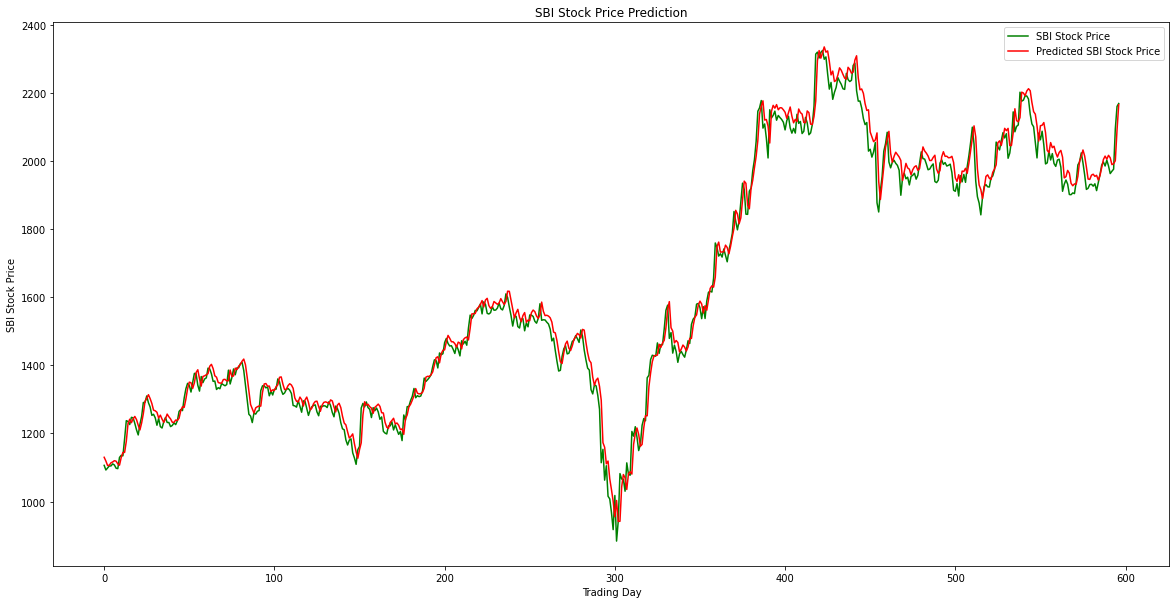

MSE: 1524.800044869172
MAE: 28.953652458254815
RMSE: 39.04868813249905
MAPE: 0.018386677043348253


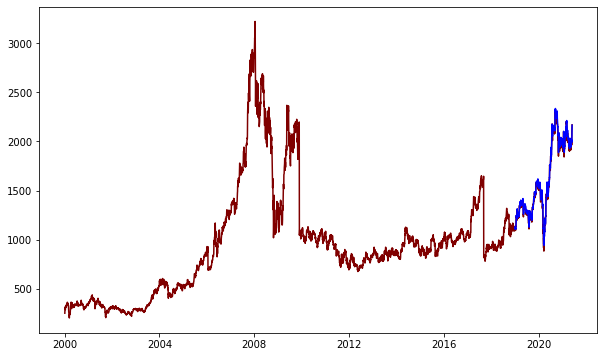

In [77]:
my_function(45,dictt)

60 days

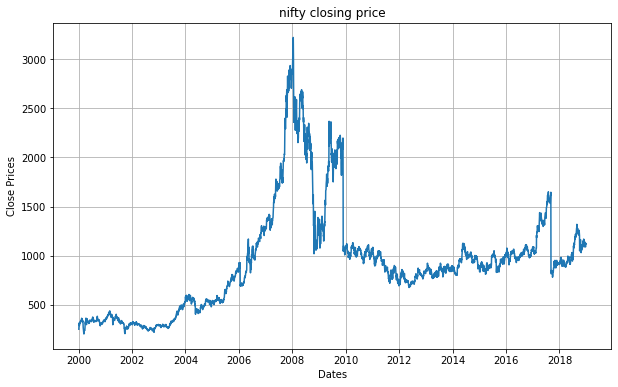

Epoch 1/100
146/146 [==============================] - 15s 72ms/step - loss: 0.0128
Epoch 2/100
146/146 [==============================] - 11s 76ms/step - loss: 0.0020
Epoch 3/100
146/146 [==============================] - 11s 75ms/step - loss: 0.0017
Epoch 4/100
146/146 [==============================] - 10s 70ms/step - loss: 0.0017
Epoch 5/100
146/146 [==============================] - 10s 72ms/step - loss: 0.0014
Epoch 6/100
146/146 [==============================] - 10s 71ms/step - loss: 0.0015
Epoch 7/100
146/146 [==============================] - 11s 72ms/step - loss: 0.0010
Epoch 8/100
146/146 [==============================] - 10s 71ms/step - loss: 0.0012
Epoch 9/100
146/146 [==============================] - 10s 71ms/step - loss: 0.0011
Epoch 10/100
146/146 [==============================] - 11s 74ms/step - loss: 0.0010
Epoch 11/100
146/146 [==============================] - 10s 72ms/step - loss: 0.0011
Epoch 12/100
146/146 [==============================] - 11s 73ms/step - lo

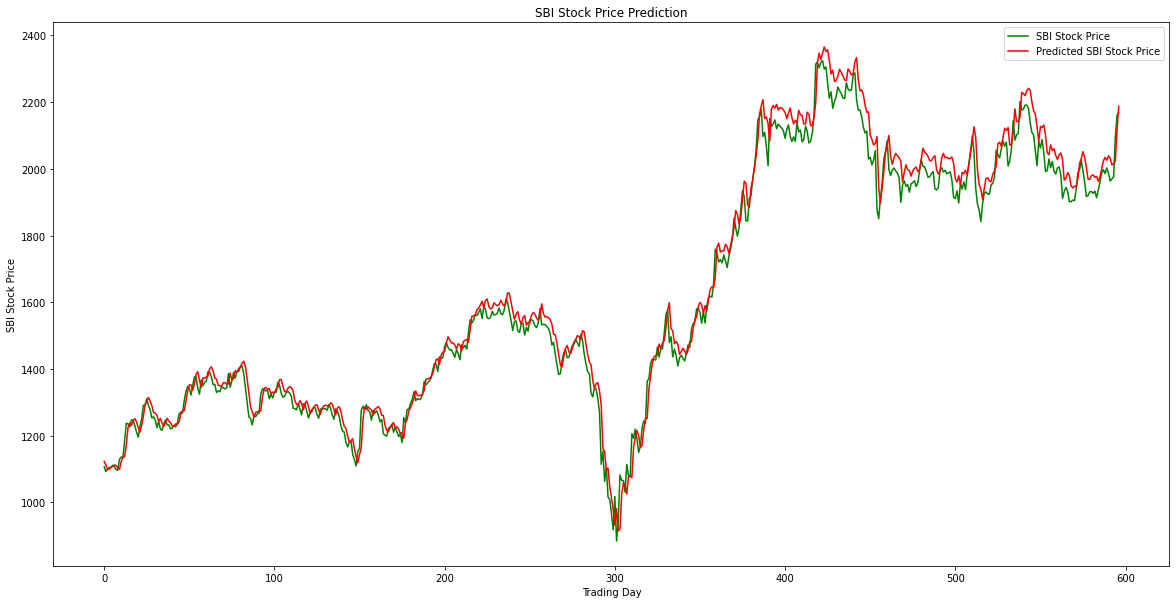

MSE: 2137.1514290166765
MAE: 35.071369911078826
RMSE: 46.229335156550505
MAPE: 0.021485381998376393


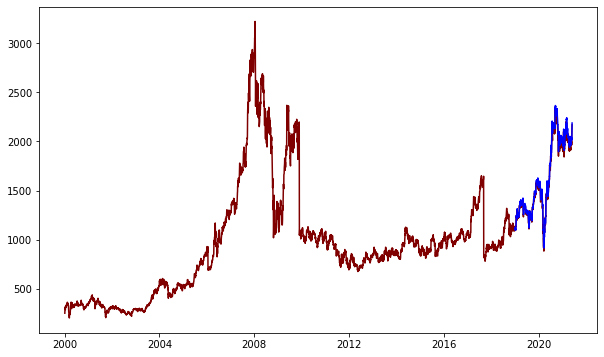

In [78]:
my_function(60,dictt)

75 days

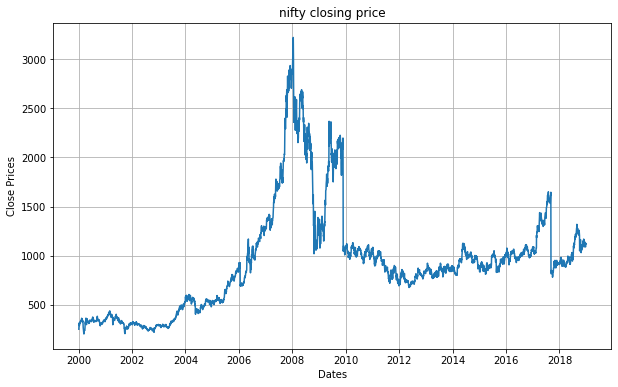

Epoch 1/100
146/146 [==============================] - 21s 111ms/step - loss: 0.0152
Epoch 2/100
146/146 [==============================] - 16s 112ms/step - loss: 0.0020
Epoch 3/100
146/146 [==============================] - 15s 105ms/step - loss: 0.0017
Epoch 4/100
146/146 [==============================] - 16s 108ms/step - loss: 0.0019
Epoch 5/100
146/146 [==============================] - 16s 109ms/step - loss: 0.0015
Epoch 6/100
146/146 [==============================] - 16s 109ms/step - loss: 0.0013
Epoch 7/100
146/146 [==============================] - 16s 107ms/step - loss: 0.0014
Epoch 8/100
146/146 [==============================] - 16s 109ms/step - loss: 0.0012
Epoch 9/100
146/146 [==============================] - 16s 106ms/step - loss: 0.0012
Epoch 10/100
146/146 [==============================] - 16s 107ms/step - loss: 0.0013
Epoch 11/100
146/146 [==============================] - 16s 107ms/step - loss: 0.0011
Epoch 12/100
146/146 [==============================] - 16s 109

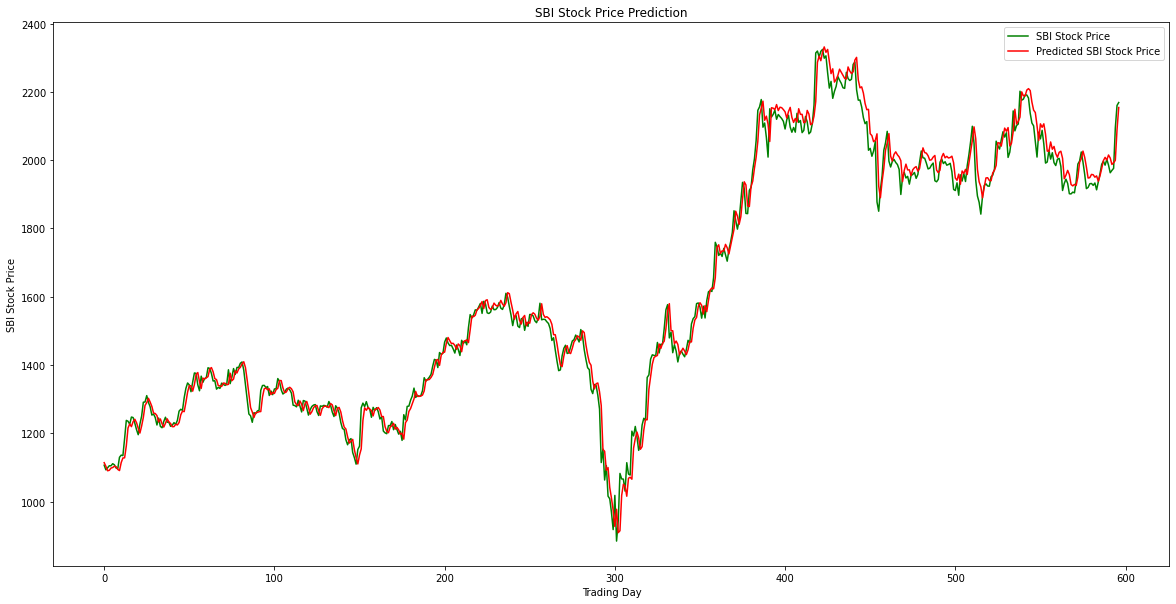

MSE: 1420.2334699617493
MAE: 27.18535054013557
RMSE: 37.685985060254815
MAPE: 0.01717362352823548


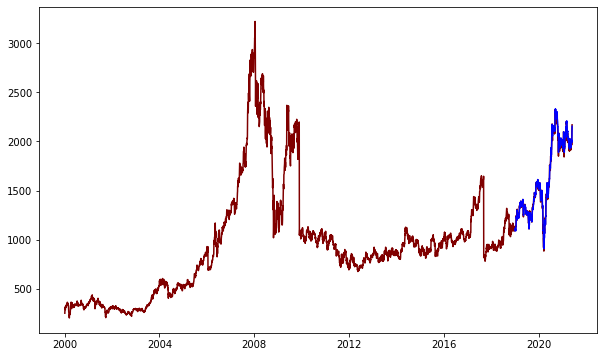

In [79]:
my_function(75,dictt)

90 days

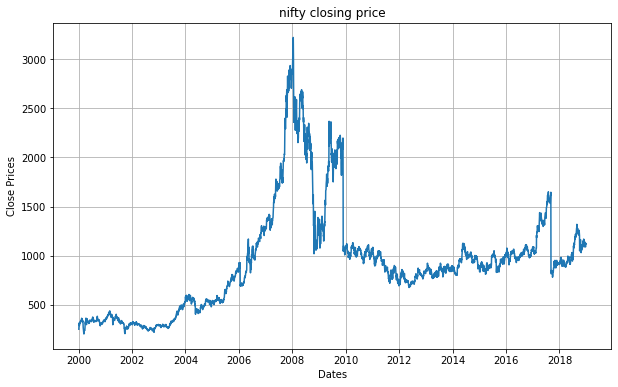

Epoch 1/100
146/146 [==============================] - 25s 127ms/step - loss: 0.0147
Epoch 2/100
146/146 [==============================] - 18s 126ms/step - loss: 0.0023
Epoch 3/100
146/146 [==============================] - 18s 124ms/step - loss: 0.0020
Epoch 4/100
146/146 [==============================] - 18s 124ms/step - loss: 0.0021
Epoch 5/100
146/146 [==============================] - 18s 126ms/step - loss: 0.0014
Epoch 6/100
146/146 [==============================] - 18s 125ms/step - loss: 0.0015
Epoch 7/100
146/146 [==============================] - 18s 124ms/step - loss: 0.0020
Epoch 8/100
146/146 [==============================] - 18s 126ms/step - loss: 0.0014
Epoch 9/100
146/146 [==============================] - 18s 124ms/step - loss: 0.0011
Epoch 10/100
146/146 [==============================] - 18s 124ms/step - loss: 0.0011
Epoch 11/100
146/146 [==============================] - 18s 124ms/step - loss: 0.0013
Epoch 12/100
146/146 [==============================] - 18s 125

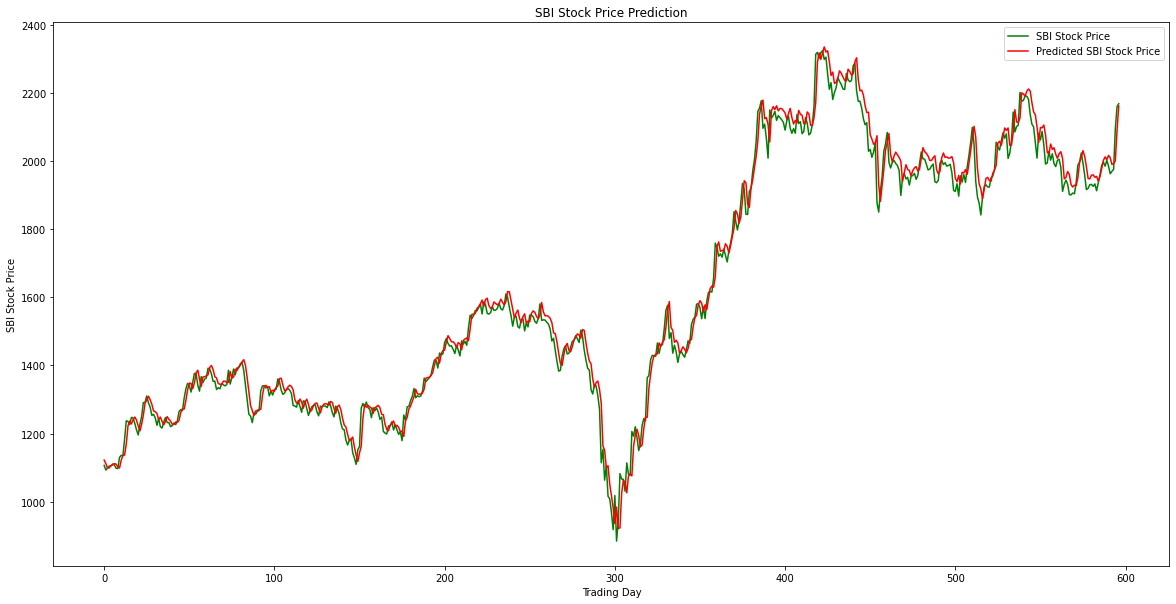

MSE: 1452.2725701848738
MAE: 27.880498664383108
RMSE: 38.108694154810316
MAPE: 0.017641922838701137


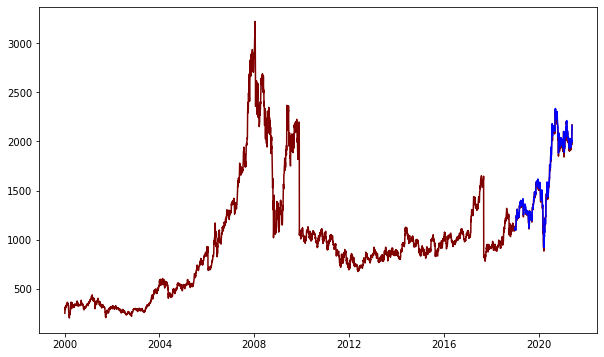

In [80]:
my_function(90,dictt)

105 days

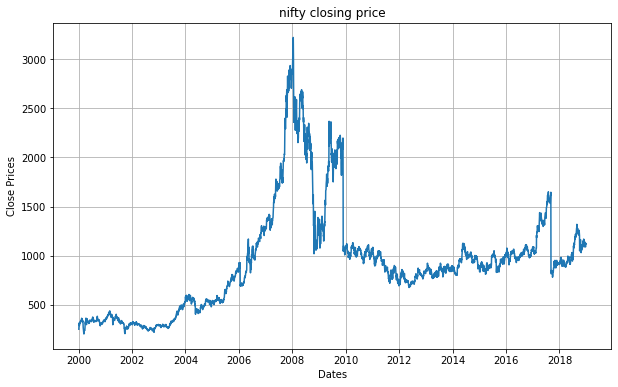

Epoch 1/100
145/145 [==============================] - 53s 317ms/step - loss: 0.0113
Epoch 2/100
145/145 [==============================] - 45s 311ms/step - loss: 0.0021
Epoch 3/100
145/145 [==============================] - 45s 313ms/step - loss: 0.0020
Epoch 4/100
145/145 [==============================] - 45s 310ms/step - loss: 0.0017
Epoch 5/100
145/145 [==============================] - 48s 332ms/step - loss: 0.0015
Epoch 6/100
145/145 [==============================] - 45s 311ms/step - loss: 0.0013
Epoch 7/100
145/145 [==============================] - 45s 308ms/step - loss: 0.0012
Epoch 8/100
145/145 [==============================] - 51s 349ms/step - loss: 0.0012
Epoch 9/100
145/145 [==============================] - 69s 470ms/step - loss: 0.0010
Epoch 10/100
145/145 [==============================] - 47s 322ms/step - loss: 0.0013
Epoch 11/100
145/145 [==============================] - 46s 315ms/step - loss: 0.0011
Epoch 12/100
145/145 [==============================] - 45s 313

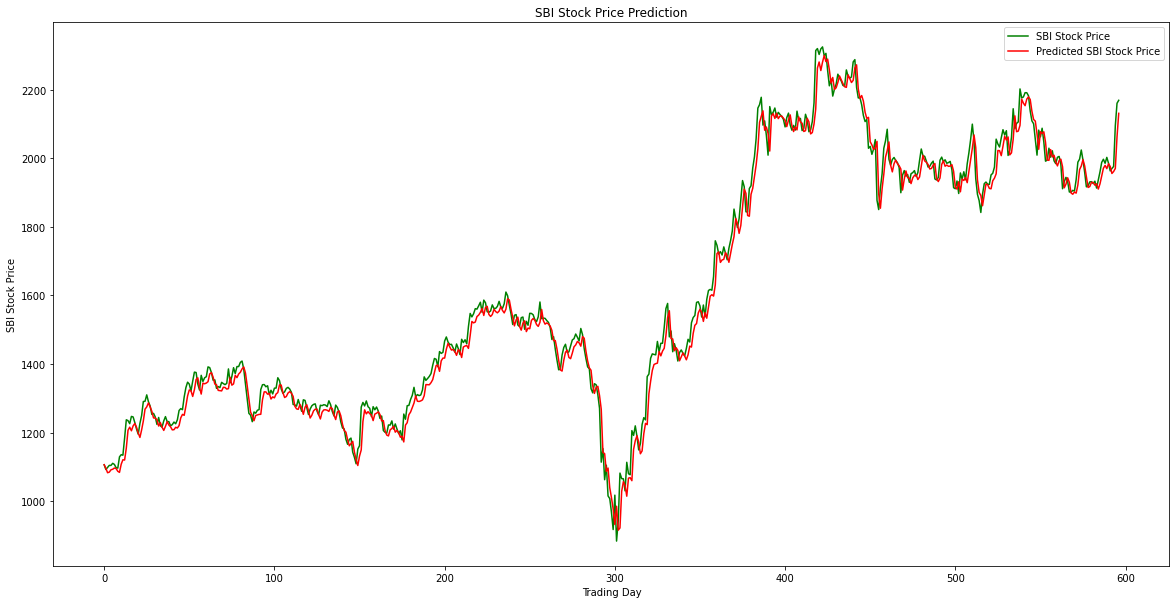

MSE: 1459.0974355174365
MAE: 27.92073066749764
RMSE: 38.19813392716242
MAPE: 0.017958424008340933


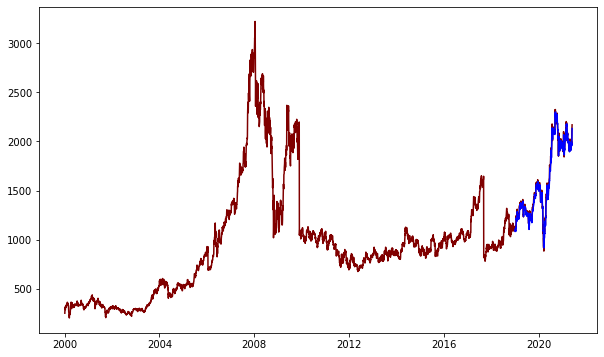

In [88]:
my_function(105,dictt)

500 days

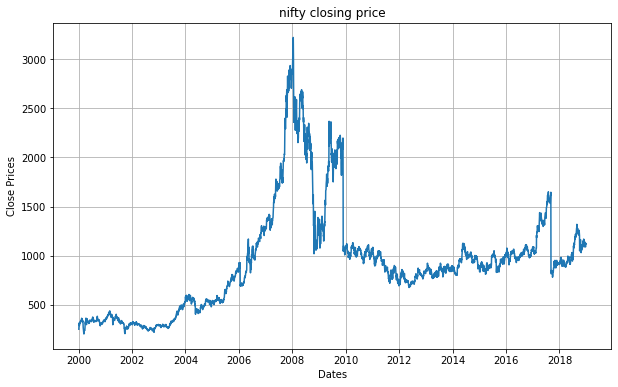

Epoch 1/100
133/133 [==============================] - 88s 513ms/step - loss: 0.0162
Epoch 2/100
133/133 [==============================] - 68s 509ms/step - loss: 0.0029
Epoch 3/100
133/133 [==============================] - 70s 529ms/step - loss: 0.0020
Epoch 4/100
133/133 [==============================] - 68s 513ms/step - loss: 0.0019
Epoch 5/100
133/133 [==============================] - 70s 524ms/step - loss: 0.0019
Epoch 6/100
133/133 [==============================] - 73s 550ms/step - loss: 0.0015
Epoch 7/100
133/133 [==============================] - 75s 563ms/step - loss: 0.0014
Epoch 8/100
133/133 [==============================] - 72s 544ms/step - loss: 0.0014
Epoch 9/100
133/133 [==============================] - 72s 537ms/step - loss: 0.0012
Epoch 10/100
133/133 [==============================] - 71s 535ms/step - loss: 0.0015
Epoch 11/100
133/133 [==============================] - 71s 534ms/step - loss: 0.0012
Epoch 12/100
133/133 [==============================] - 72s 543

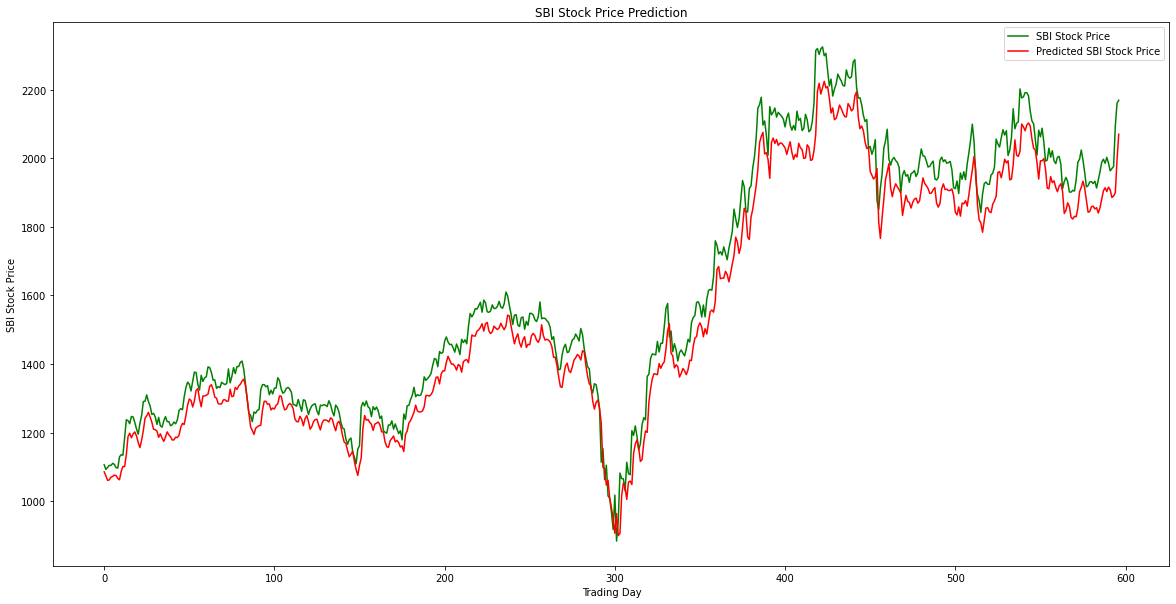

MSE: 5537.46478190224
MAE: 65.59858343229821
RMSE: 74.41414369528309
MAPE: 0.04015338842573497


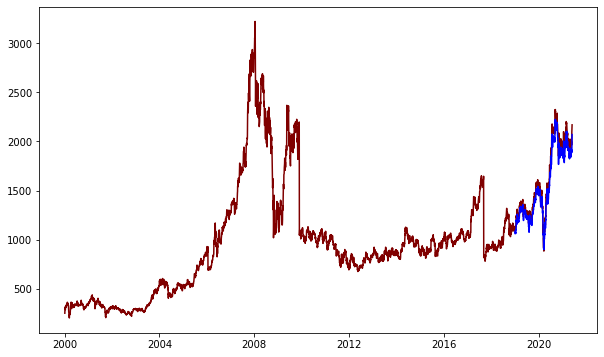

In [6]:
my_function(500,dictt)

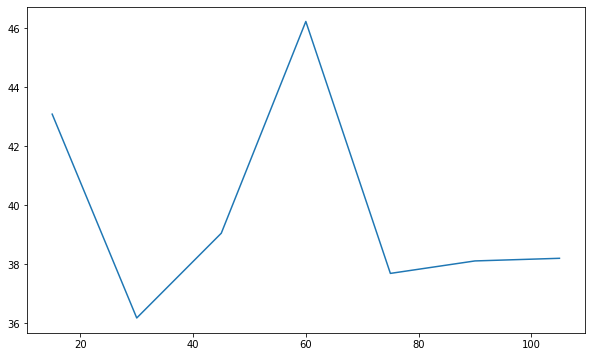

In [89]:
#import matplotlib.pylab as plt

#my_dict = { 'Khan': 4, 'Ali': 2, 'Luna': 6, 'Mark': 11, 'Pooja': 8, 'Sara': 1}

myList = dictt.items()
myList = sorted(myList) 
x, y = zip(*myList) 

plt.plot(x, y)
plt.show()

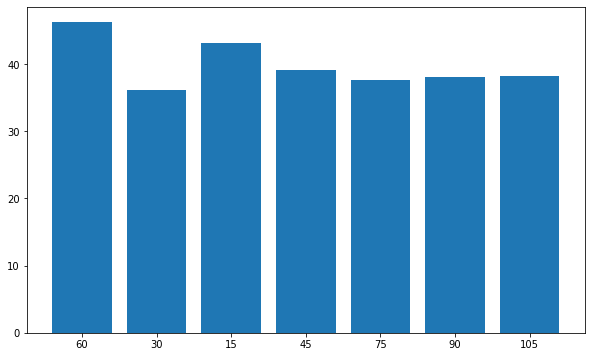

In [90]:
import matplotlib.pyplot as plt

#D = {u'Label1':26, u'Label2': 17, u'Label3':30}

plt.bar(range(len(dictt)), list(dictt.values()), align='center')
plt.xticks(range(len(dictt)), list(dictt.keys()))
plt.title('RMSE error vs no of days')
plt.xlabel('No of Day')
plt.ylabel('RMSE error')
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()

75 new wala with diffrent parameter trained

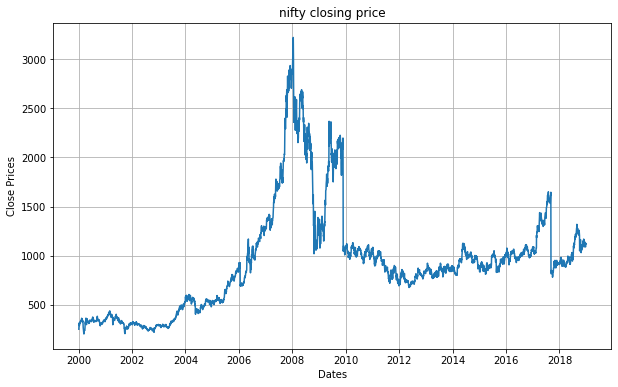

Epoch 1/100
146/146 [==============================] - 34s 178ms/step - loss: 0.0123
Epoch 2/100
146/146 [==============================] - 27s 183ms/step - loss: 0.0013
Epoch 3/100
146/146 [==============================] - 24s 161ms/step - loss: 0.0014
Epoch 4/100
146/146 [==============================] - 24s 164ms/step - loss: 0.0012
Epoch 5/100
146/146 [==============================] - 23s 156ms/step - loss: 7.4408e-04
Epoch 6/100
146/146 [==============================] - 23s 159ms/step - loss: 7.9198e-04
Epoch 7/100
146/146 [==============================] - 23s 157ms/step - loss: 8.3304e-04
Epoch 8/100
146/146 [==============================] - 23s 160ms/step - loss: 9.1811e-04
Epoch 9/100
146/146 [==============================] - 22s 153ms/step - loss: 6.2951e-04
Epoch 10/100
146/146 [==============================] - 23s 159ms/step - loss: 8.0663e-04
Epoch 11/100
146/146 [==============================] - 22s 154ms/step - loss: 5.7734e-04
Epoch 12/100
146/146 [=============

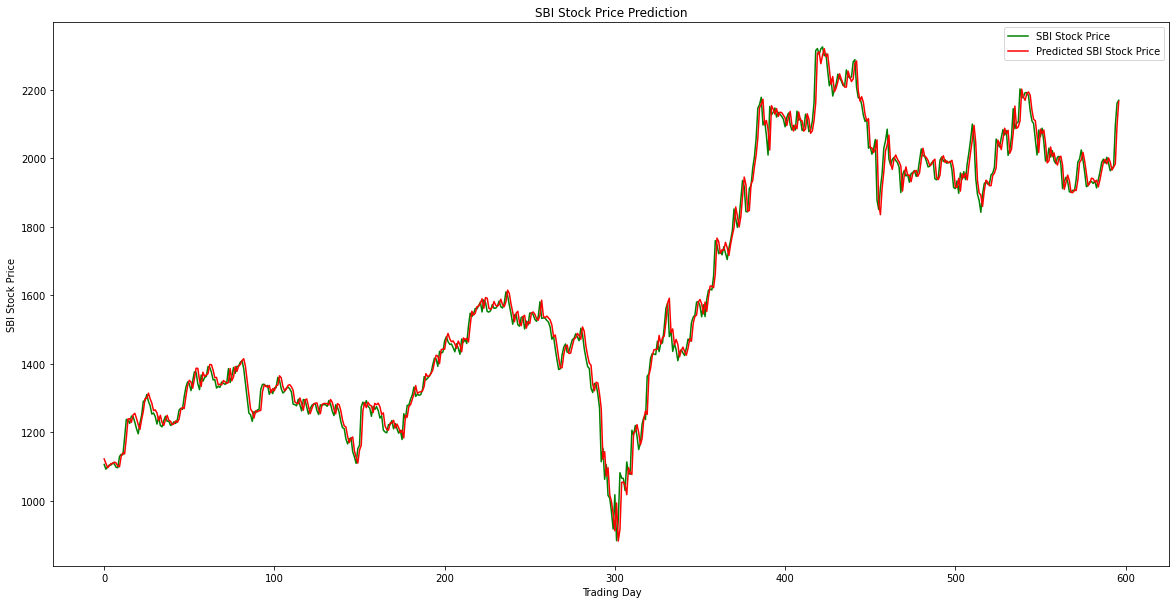

MSE: 1172.6335541495707
MAE: 24.314063890415614
RMSE: 34.24373744423308
MAPE: 0.015636099354337348


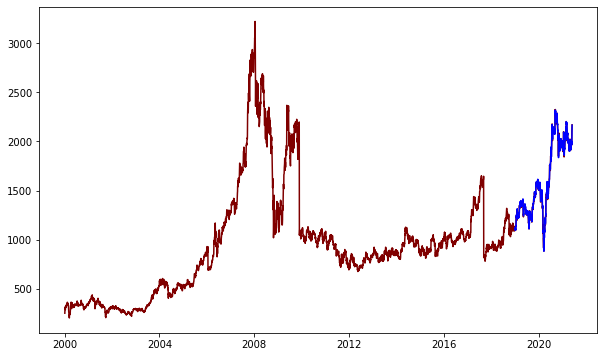

In [8]:
my_function(75,dictt)